# QuClassi
The original paper is [`QuClassi: A Hybrid Deep Neural Network Architecture based on Quantum State Fidelity`](https://arxiv.org/pdf/2103.11307).

The following explanation is what I believe, so please freely contact me about anything on the codes or the description below.

In [1]:
# Set paths in order to import packages correctly.
import sys
import os
sys.path.append(os.path.abspath("./../..")) 
sys.path.append("./../../src")

import src.utils as utils
utils.fix_seed(901)

## General Idea
QuClassi is a quantum-classical hybrid neural network for both binary and multi classification leveraging the power of variational quantum ciruits. Although we do not really need to have many quantum circuits, for the sake of ease, we may think QuClassi has $m$ quantum circuits, where $m$ is the number of classes. For instance, if it is a binary classification task, then $m = 2$. Each circuit is constructed with three parts; 1. control qubit, 2. trained qubits and 3. loaded qubits. The number of contol qubit is always one. Meanwhile, the numbers of trained and loaded qubits vary according to the input data, yet those two are the same. Roughly speaking, the number of qubits in each circuit is $d + 1$, where $d$ is the dimension of the input data. The trained qubits are, as the name represents, trained through the training algorithm and the loaded qubits is used for encoding the input data. The controle qubit is used to know how similar the loaded qubits and trained qubits are. More precisely, the qubit is measured to know the quantum fidelity between them. Let's consider the specific case. The task is a binary classification and the input data is $4$-dimensional data. Then, $m = 2$ and $d = 4$, hence we have 2 quantum circuits of which the number of qubits is $d + 1 = 5$.

The general idea of QuClassi is finding and using the representative quantum states corresponding to each class in the Hilbert space. Through the training process, the parameters of gates applying to the trained qubits are updated. After the training process, QuClassi classifies the input data by comparing the fidelities calculated from each quantum circuit. Let's go into one of the simplest examples. Think of a binary classification and the dimesion of the data is two. Suppose the first quantum circuit corresponding to the class `0` obtained $|0>$ state as the trained qubits and the other corresponding to the class `1` did $|1>$. This QuClassi calculates the fidelities $|<x|0>|^2$ and $|<x|1>|^2$ for an input state $|x>$ corresponding to the input data $x$ and classify the data to either class `0` or `1` whose fidelity is larger. If the input data is also $|1>$ then the fidelities are $|<1|0>|^2 = 0$ and $|<1|1>|^2 = 1$, so the data is classified to the class `1`.

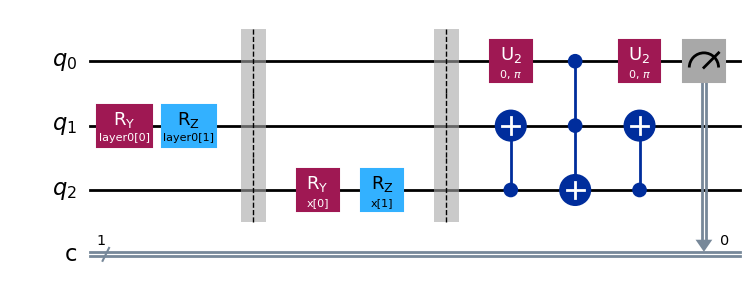

In [2]:
# Let's see the simplest example above as pieces of codes.
from src.quclassi.quclassi import QuClassi

# Create an instance of QuClassi class.
classical_data_size = 2
labels = ["0", "1"]
simplest_quclassi = QuClassi(classical_data_size=classical_data_size, labels=labels)

# This part is seen later on, so ignore this.
simplest_structure = "s"
simplest_quclassi.build(structure=simplest_structure)

# Check the circuit.
simplest_quclassi.circuit.decompose().draw("mpl")

The `q_0` above is the control qubit, `q_1` is the trained qubit and `q_2` is the loaded qubit.

By the way, we regarded QuClassi as bunch of quantum circuits in the first explanation, however, if we implement it as a parametrised circuit, then the one circuit can be used for all the classes. Indeed, my implementation is done so. You see `layer0[0], layer0[1]` and `x[0], x[1]` in the above circuit. Those represent the parameter names.

In [3]:
import numpy as np
import src.utils as utils

parameters_0 = [0, 0]  # RZ(0)RY(0)|0> = |0>
parameters_1 = [np.pi, 0]  # RZ(0)RY(pi)|0> = |1>

# Set the trained parameters.
simplest_quclassi.trained_parameters = [parameters_0, parameters_1]

simplest_input_data = np.array([np.pi, 0])  # the data parameters to prepare the loaded state as |1>

# Classify the data represented as |1>.
simplest_quclassi.classify(simplest_input_data)

'1'

In [4]:
# Check the fidelities.
simplest_quclassi.get_fidelities(simplest_input_data)

{'0': 0.07421875, '1': 1.0}

## Architecture
We will go into quantum gates applying to the trained and loaded qubits. To encode the data into the loaded qubits, the angle encoding method is proposed in the original. Think of a classical input data $x = (x_1, x_2, \dots, x_d)$. The first entry is encoded as $RY(\theta_1)$, where $\theta_1 = 2 \arcsin{\sqrt{x_1}}$, to the first loaded qubit. The second entry is encoded as $RZ(\theta_2)$, where $\theta_2 = 2 \arcsin{\sqrt{x_2}}$, to the first loaded qubit. The third and fourth entries are encoded as same as the first and second ones but the gates are applied to the second loaded qubit. The following entries are done in the same way. Although the original paper only mentioned the angle encoding, the paper, [`Comparing Quantum Encoding Techniques`](https://arxiv.org/pdf/2410.09121) published on quant-ph in October 2024, compared the other encoding methods in a spacific dataset.

The gates applying to the trained qubits are a little bit more complecated. In the original paper, three layers, which are sets of quantum gates, are proposed; 1. single qubit unitary gate, 2. dual qubit unitary gate and 3. entanglement unitary gate. The single qubit unitary gate is constructed with RY and RZ gates, the dual qubit unitary gate is RRY and RRZ, and the entanglement unitary gate is CRY and CRZ. The user can specify the actual structure constructed with those three kinds of layers in an arbitrary order. As the nature of RRY, RRZ, CRY and CRZ gates, if the input data is two-dimensional, then the only available layer is the single qubit unitary layer.

In my implementation, the structure is specified as the argument `structure` of `build` function. `"s"`, `"d"` and `"e"` represent single qubit, dual qubit and entanglement unitary layers, respectively.

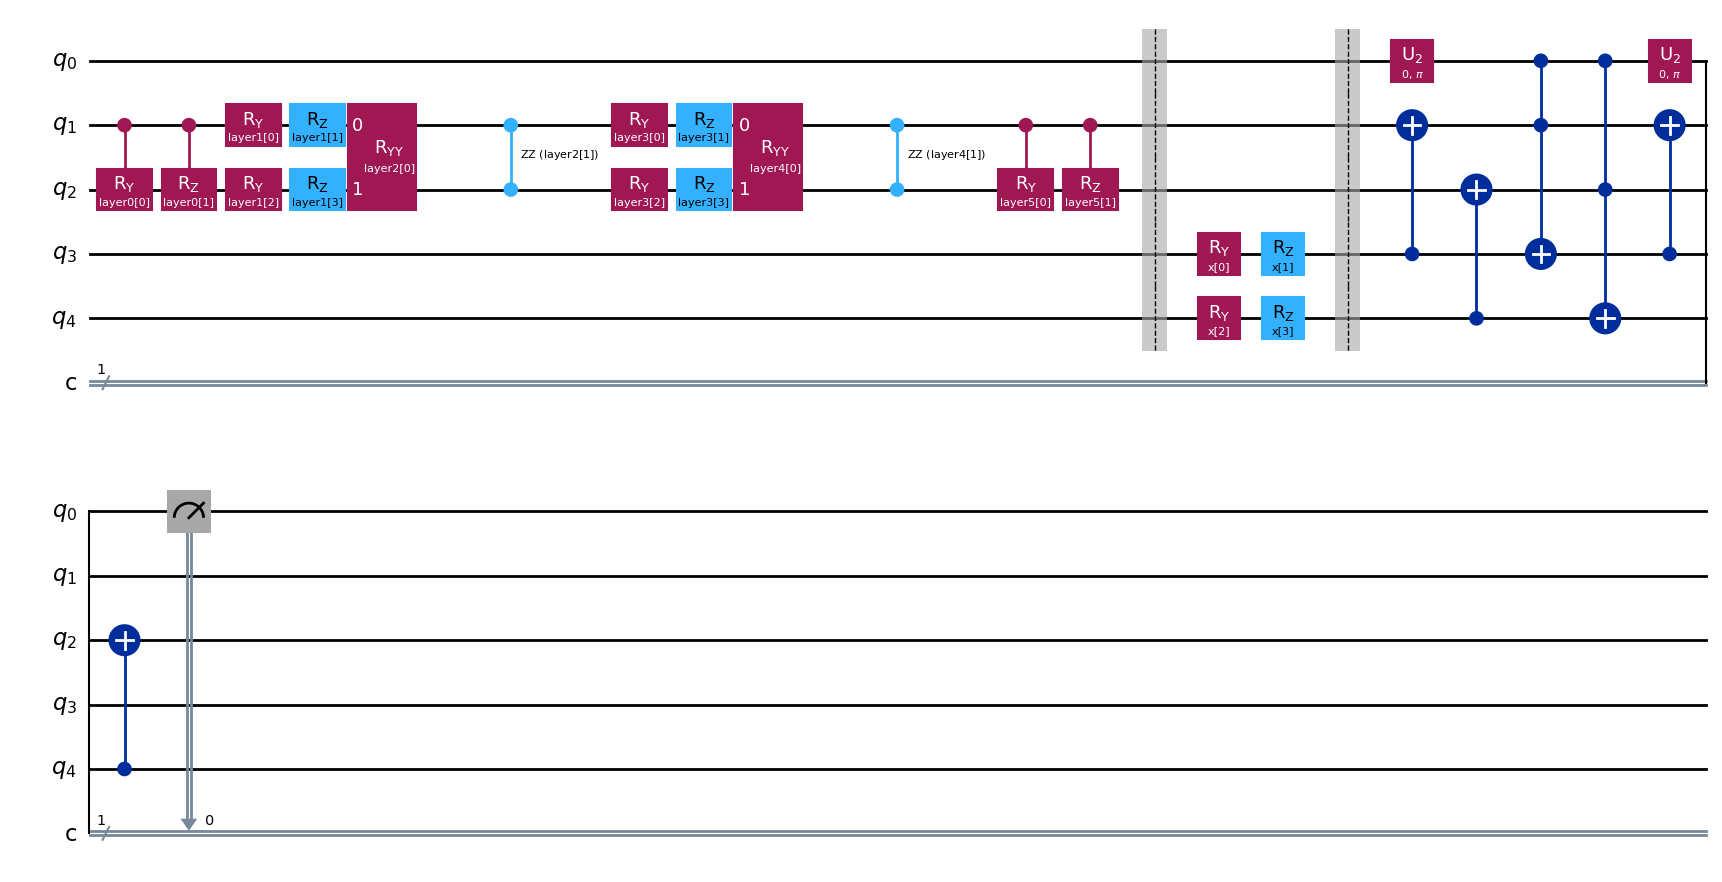

In [5]:
# Create an instance of Quclassi class having 2 qubits each for the trained and loaded qubits.
classical_data_size = 4
quclassi = QuClassi(classical_data_size=classical_data_size, labels=labels)

structure = "esdsde"  # entanglement, single qubit, dual qubit, single qubit, dual qubit, entanglement
quclassi.build(structure=structure)
quclassi.circuit.decompose().draw("mpl")

## Training Process

The details of the training process are not mentioned here but see Section 4.5 Training and Inducing QuClassi in the original paper. The rough concept is as follows. Again, for the sake of ease, assume QuClassi has $m$ quantum circuits, where $m$ is the number of the classes. First, separate the dataset into $m$ parts of data, hereby called sub-dataset, by the labels. Train each quantum circuit with the corresponding sub-dataset. Run the circuit with a little bit shifted current parameters and calculate the update-term and update the current parameters by it.

In my implementation, the training process is implemented in `src/quclassi/quclassi_trainer.py`.

In [6]:
# Get the artificial dataset.
import src.dataset as dataset
data, labels = dataset.get_large_small()

# Prepare the dataset.
import src.quclassi.train as train
train_data, train_labels, val_data, val_labels = train.preprocess_dataset(
    data=data, labels=labels, should_scale=True, encoding_method=utils.encode_through_arcsin
)

# Get unique labels.
import numpy as np
unique_labels = np.unique(labels).tolist()
unique_labels

['large', 'small']

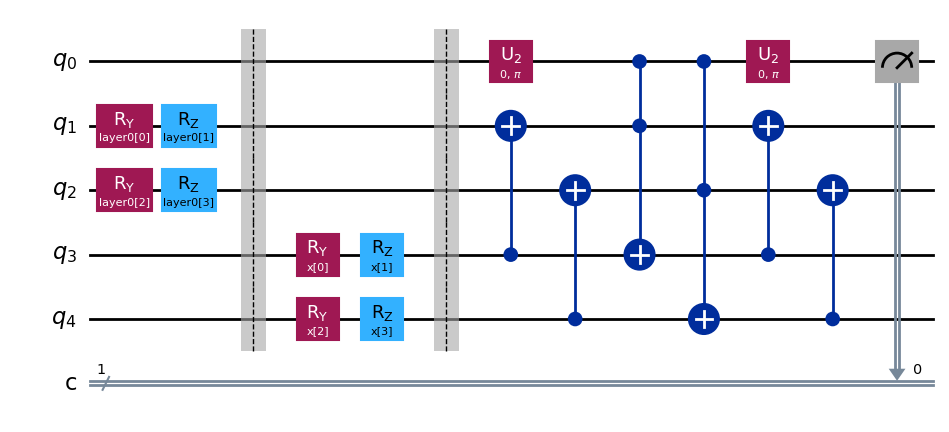

In [7]:
# Create the appropriate QuClassi.
quclassi = QuClassi(classical_data_size=len(train_data[0]), labels=unique_labels)
quclassi.build(structure="s")

# Check the circuit.
quclassi.circuit.decompose().draw("mpl")

In [8]:
from src.quclassi.quclassi_trainer import QuClassiTrainer

# Check the accuracy without training.
quclassi_trainer = QuClassiTrainer(quclassi=quclassi, epochs=0)
quclassi_trainer.train(train_data=train_data, train_labels=train_labels, val_data=val_data, val_labels=val_labels)

0it [00:00, ?it/s]

Train Accuracy: 0.36
Validation Accuracy: 0.4


In [9]:
# Train the QuClassi
quclassi_trainer = QuClassiTrainer(quclassi=quclassi, epochs=25, initial_parameters=quclassi.trained_parameters)
quclassi_trainer.train(train_data=train_data, train_labels=train_labels, val_data=val_data, val_labels=val_labels)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Train Accuracy: 0.7466666666666667
Validation Accuracy: 0.6
